<a href="https://colab.research.google.com/github/LapTQ/mlapplications/blob/main/ML_applications.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Facial beauty perception

In [1]:
!git clone https://github.com/LapTQ/mlapplications.git

Cloning into 'mlapplications'...
remote: Enumerating objects: 17, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 17 (delta 1), reused 11 (delta 0), pack-reused 0
Unpacking objects: 100% (17/17), done.


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import math

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from keras.models import Model
from google.colab import files

import pathlib
import tempfile
import shutil
from IPython import display

from matplotlib import gridspec

seed = 42

image_size = (124, 124)
channels = 1

input_shape = image_size + (channels,)

resize_and_scale = tf.keras.Sequential(
    [
     tf.keras.layers.Resizing(*image_size, crop_to_aspect_ratio=True),
     tf.keras.layers.Rescaling(1./255), # use offset=-1 if wanted it to be [-1, 1]
     ]
)

fbp_model = tf.keras.models.load_model('/content/mlapplications/trained_models/fbp')

def plot_img(img, pred):
    plt.imshow(np.squeeze(img), cmap='gray' if channels == 1 else 'rgb')
    plt.title('pred: %.2f' % (pred.squeeze()), color='firebrick')
    plt.axis('off')

def plot_scores(score):
    score = np.squeeze(score)
    this_plot = plt.bar(['pred'], [score])
    this_plot[0].set_color('firebrick')
    plt.yticks(range(6))


Saving 00.png to 00 (1).png
Uploaded "00.png" of 74863 bytes


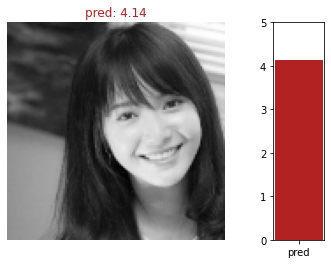

In [5]:
#@title Tải ảnh lên và tiến hành dự đoán

from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
    print('Uploaded "{}" of {} bytes'.format(fn, len(uploaded[fn])))

    img = image.load_img(fn, color_mode='grayscale' if channels == 1 else None)
    
    img = image.img_to_array(img)
    img = resize_and_scale(img)

    pred = fbp_model.predict(np.expand_dims(img, axis=0))

    spec = gridspec.GridSpec(ncols=2, nrows=1, width_ratios=[5, 1])
    plt.subplot(spec[0])
    plot_img(img, pred)
    plt.subplot(spec[1])
    plot_scores(pred)

    plt.show()

    